# Overview
- スタッキングを試してみる 

# Import everything I need :)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
import multiprocessing
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from fastprogress import progress_bar

# Preparation

In [2]:
nb = 75
isSmallSet = False
length = 10000
model_name = 'ridge'

In [3]:
pd.set_option('display.max_columns', 200)

In [4]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/mulliken_charges.csv',
 '../input/champs-scalar-coupling/structures.zip',
 '../input/champs-scalar-coupling/train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/nb33_test_dist-interaction.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/nb47_fc_test.csv',
 '../input/champs-scalar-coupling/nb33_train_dist-interaction.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupling/sample_submission.csv',
 '../input/champs-scalar-coupling/nb29_fc_test_feature.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/nb47_fc_train.csv',


In [5]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)
    
type_train = train.type.values

In [6]:
# train
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path) [:length]
else:
    test = pd.read_csv(path)
    
type_test = test.type.values

## myFunc
**metrics**

In [7]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

# Stacking

In [40]:
path_list = [
'nb54_{}_random_forest_regressor_-1.45569.csv',
'nb57_{}_lasso_-1.07263.csv',
'nb60_{}_lgb_-1.5330660525700779.csv',
'nb63_{}_ridge_-1.37017.csv',
'nb69_{}_ridge_-1.24324.csv',
'nb69_{}_ridge_-1.24325.csv',
'nb70_{}_ridge_-1.18702.csv',
'nb70_{}_ridge_-1.18703.csv',
'nb71_{}_lasso_-1.17648.csv',
]

In [41]:
# oof
oofs = []
for path in path_list:
    if isSmallSet:
        df = pd.read_csv('./../output/' + path.format('oof'))[:length]
    else:
        df = pd.read_csv('./../output/' + path.format('oof'))
    oofs.append(df)

In [42]:
# sub
subs = []
for path in path_list:
    if isSmallSet:
        df = pd.read_csv('./../output/' + path.format('submission')).drop(['id'], axis=1)[:length]
    else:
        df = pd.read_csv('./../output/' + path.format('submission')).drop(['id'], axis=1)
    subs.append(df)

# Create train, test data

In [35]:
X.head()

,nb54_{}_random_forest_regressor_-1.45569.csv,nb57_{}_lasso_-1.07263.csv,nb60_{}_lgb_-1.5330660525700779.csv,nb63_{}_ridge_-1.37017.csv,nb69_{}_ridge_-1.24324.csv,nb69_{}_ridge_-1.24325.csv,nb70_{}_ridge_-1.18702.csv,nb70_{}_ridge_-1.18703.csv,nb71_{}_lasso_-1.17648.csv
0,83.937735,84.360241,86.062973,85.363372,84.166291,84.164338,84.572008,84.569395,84.344518
1,-11.042239,-10.795751,-11.026408,-10.864129,-10.978472,-10.981263,-10.911054,-10.910718,-10.924129
2,-10.300220,-10.593540,-11.167362,-10.677221,-10.767484,-10.769885,-10.704512,-10.704830,-10.716293
3,-11.082782,-10.901052,-11.329790,-10.958626,-11.086977,-11.084271,-11.016241,-11.017092,-11.028413
4,84.637397,85.614153,85.801094,86.635412,85.407988,85.402040,85.824345,85.824603,85.596216


LabelEncode
- `type`   = {2JHC, ...}

In [33]:
lbl = LabelEncoder()
lbl.fit(list(type_train) + list(type_test))
type_train_lbl = lbl.transform(type_train)
type_test_lbl = lbl.transform(type_test)

In [43]:
y = train.scalar_coupling_constant
X = pd.concat(oofs, axis=1)
X = pd.DataFrame(X.values, columns=path_list)
X_test = pd.concat(subs, axis=1)
X_test = pd.DataFrame(X_test.values, columns=path_list)

# Training model

**params**

In [44]:
# Configuration
MAX_ITER = 10000
RANDOM_STATE = 0

model_params_list = [
 {'alpha': 0.016490786888660246},
 {'alpha': 0.01948297047624237},
 {'alpha': 0.01181445773799895},
 {'alpha': 0.01},
 {'alpha': 0.17022936642711317},
 {'alpha': 0.9019291300867383},
 {'alpha': 1.2589254117941673},
 {'alpha': 0.5469291042181513}]

In [45]:
n_folds = 6
folds = KFold(n_splits=n_folds, shuffle=True)

In [46]:
def train_model(X, X_test, y, folds, model_params):
    model = linear_model.Ridge(**model_params, max_iter=MAX_ITER, random_state=RANDOM_STATE)  # <=================

    scores = []
    oof = np.zeros(len(X))  
    prediction = np.zeros(len(X))  
    result_dict = {}
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        model.fit(X.iloc[train_idx, :], y[train_idx])
        y_valid_pred = model.predict(X.iloc[valid_idx, :])
        y_train_pred = model.predict(X.iloc[train_idx, :])
        prediction = model.predict(X_test)
        oof[valid_idx] = y_valid_pred
        score = mean_absolute_error(y[valid_idx], y_valid_pred)
        score_train = mean_absolute_error(y[train_idx], y_train_pred)
        scores.append(score)

        print(f'fold {fold_n+1} train:{score_train :.5f} \t valid: {score :.5f}')
        print('')
    print('CV mean score    : {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    print('kaggle mean score: {0:.4f}'.format(np.log(np.mean(scores)))) 
    print('')
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    return result_dict

In [47]:
%%time
# type ごとの学習 

X_short = pd.DataFrame({'ind': list(X.index), 'type': type_train, 'oof': [0] * len(X), 'target': y.values})
X_short_test = pd.DataFrame({'ind': list(X_test.index), 'type': type_test, 'prediction': [0] * len(X_test)})
for i, t in enumerate(np.unique(type_train)):
    idx = lbl.transform([t])[0]
    model_params = model_params_list[idx]
    print('*'*80)
    print(f'Training of type {t}')
    print('*'*80)
    X_t = X.loc[type_train == t]
    X_test_t = X_test.loc[type_test == t]
    y_t = X_short.loc[type_train == t, 'target'].values
    
    result_dict = train_model(X_t, X_test_t, y_t, folds, model_params)
    X_short.loc[type_train == t, 'oof'] = result_dict['oof']
    X_short_test.loc[type_test == t, 'prediction'] = result_dict['prediction']
    
    

print('')
print('===== finish =====')
X['scalar_coupling_constant'] = y
X['type'] = type_train
metric = kaggle_metric(X, X_short['oof'])
X = X.drop(['scalar_coupling_constant', 'prediction', 'type'], axis=1)
print('CV mean score(group log mae): {0:.4f}'.format(metric))
prediction = X_short_test['prediction']

********************************************************************************
Training of type 1JHC
********************************************************************************
Fold 1 started at Sun Aug 25 21:41:14 2019
fold 1 train:0.62210 	 valid: 0.62579

Fold 2 started at Sun Aug 25 21:41:14 2019
fold 2 train:0.62270 	 valid: 0.62283

Fold 3 started at Sun Aug 25 21:41:14 2019
fold 3 train:0.62256 	 valid: 0.62322

Fold 4 started at Sun Aug 25 21:41:14 2019
fold 4 train:0.62273 	 valid: 0.62246

Fold 5 started at Sun Aug 25 21:41:14 2019
fold 5 train:0.62269 	 valid: 0.62265

Fold 6 started at Sun Aug 25 21:41:15 2019
fold 6 train:0.62341 	 valid: 0.61932

CV mean score    : 0.6227, std: 0.0019.
kaggle mean score: -0.4737

********************************************************************************
Training of type 1JHN
********************************************************************************
Fold 1 started at Sun Aug 25 21:41:16 2019
fold 1 train:0.33789 	 valid:

# Save

**submission**

In [48]:
# path_submittion = './output/' + 'nb{}_submission_lgb_{}.csv'.format(nb, metric)
path_submittion = f'../output/nb{nb}_stack_submission_{model_name}_{metric :.5f}.csv'
print(f'save pash: {path_submittion}')

save pash: ../output/nb75_stack_submission_ridge_-1.55617.csv


In [49]:
submittion = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')
# submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')[::100]
submittion['scalar_coupling_constant'] = prediction
if isSmallSet:
    pass
else:
    submittion.to_csv(path_submittion, index=False)

---
**result**

In [50]:
path_oof = f'../output/nb{nb}_stack_oof_{model_name}_{metric :.5f}.csv'
print(f'save pash: {path_oof}')

save pash: ../output/nb75_stack_oof_ridge_-1.55617.csv


In [51]:
oof = pd.DataFrame(X_short['oof'])
if isSmallSet:
    pass
else:
    oof.to_csv(path_oof, index=False)

# analysis

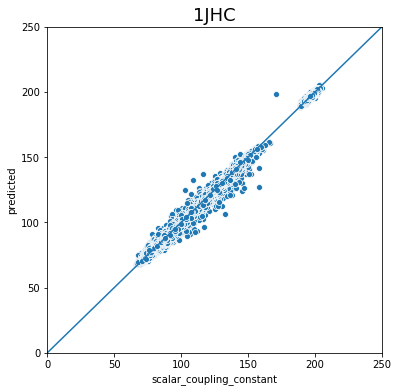

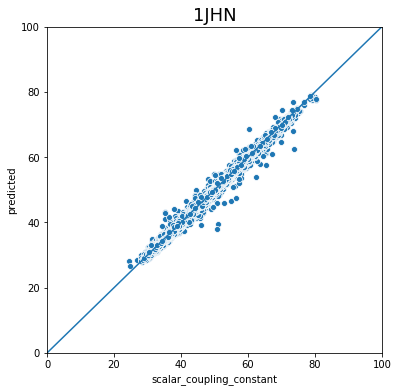

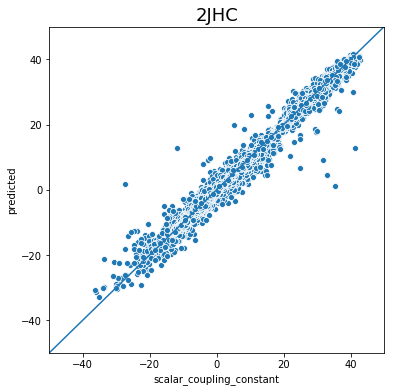

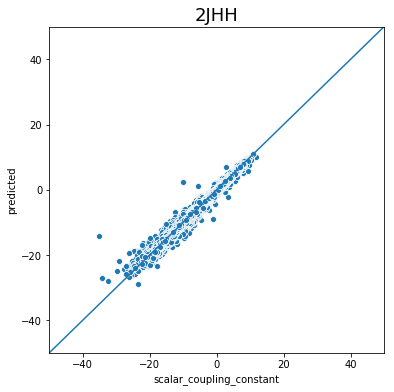

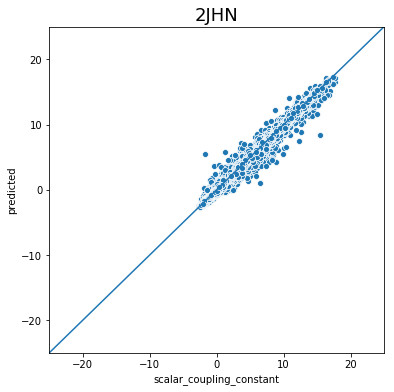

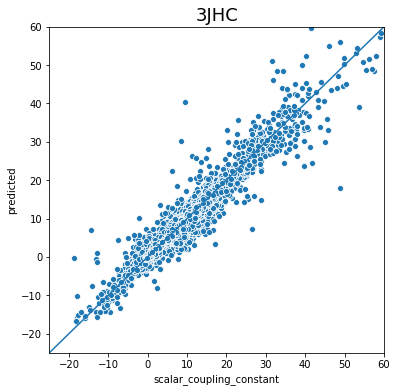

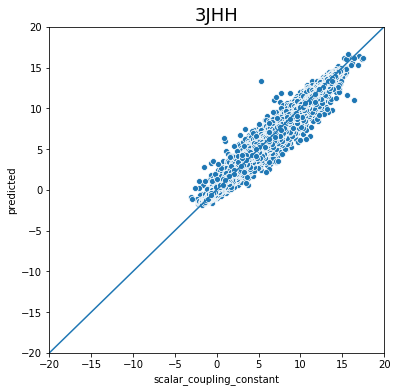

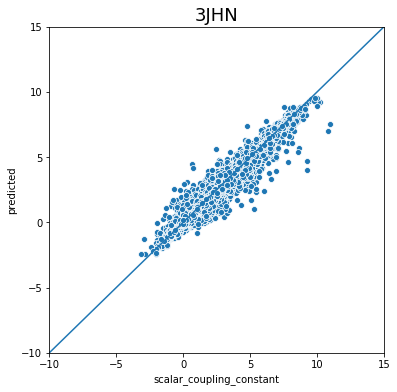

In [52]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = X_short['oof']
plot_data['type'] = type_train

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 60)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -10, 15)